🔄 Đang load dữ liệu...
Phân bố lớp: [14000. 14000. 14000. 14000. 14000. 14000. 13999. 14000. 14000. 14000.
 14000.]
✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình CNN...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                2304      
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 256)               16640     
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalizatio

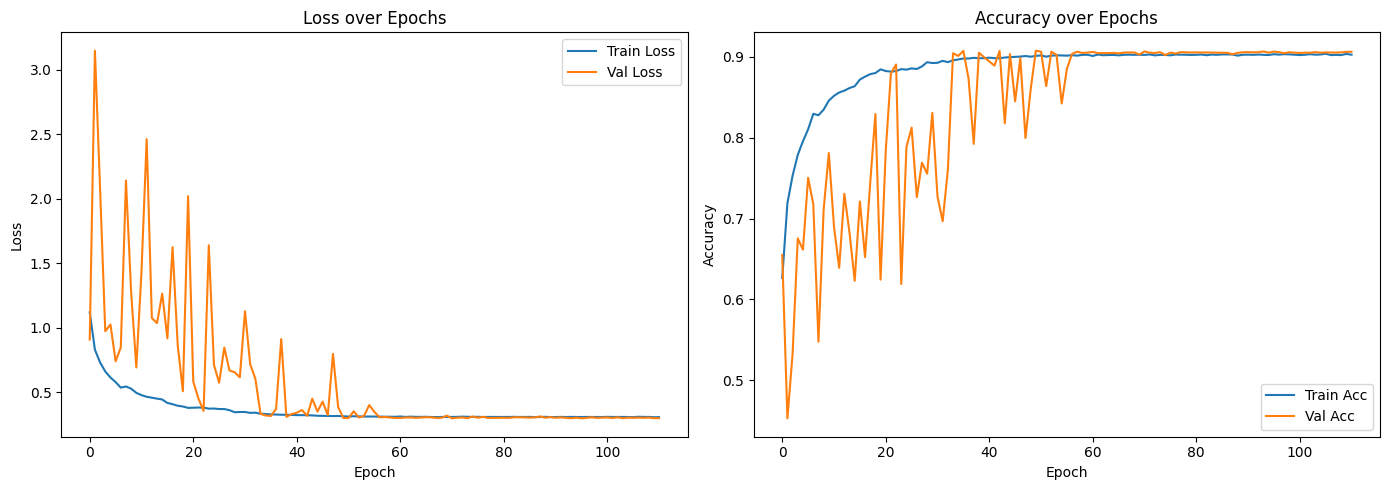

🔎 Dự đoán trên tập test...
1376/1376 [==============================] - 2s 1ms/step
📊 Ma trận nhầm lẫn:


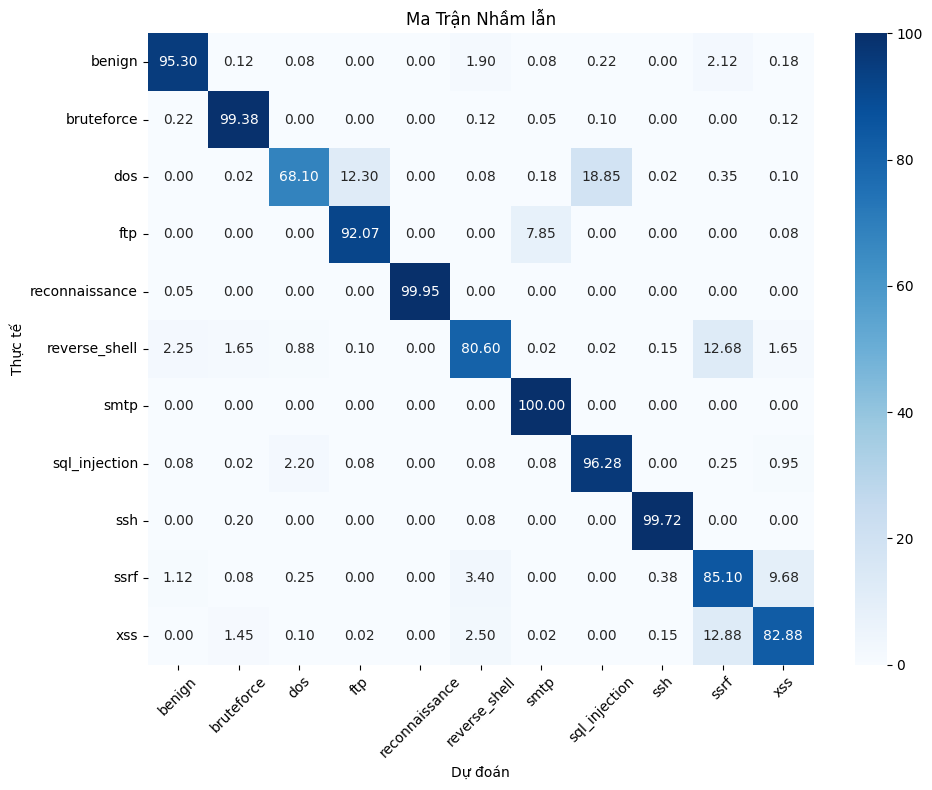


📋 Classification Report:
                precision    recall  f1-score   support

        benign     0.9624    0.9530    0.9577      4000
    bruteforce     0.9655    0.9938    0.9794      4000
           dos     0.9511    0.6810    0.7937      4000
           ftp     0.8805    0.9207    0.9002      4000
reconnaissance     1.0000    0.9995    0.9997      4000
 reverse_shell     0.9082    0.8060    0.8540      4000
          smtp     0.9236    1.0000    0.9603      4001
 sql_injection     0.8337    0.9627    0.8936      4000
           ssh     0.9930    0.9972    0.9951      4000
          ssrf     0.7506    0.8510    0.7977      4000
           xss     0.8667    0.8287    0.8473      4000

      accuracy                         0.9085     44001
     macro avg     0.9123    0.9085    0.9072     44001
  weighted avg     0.9123    0.9085    0.9072     44001


📈 Precision-Recall từng lớp:


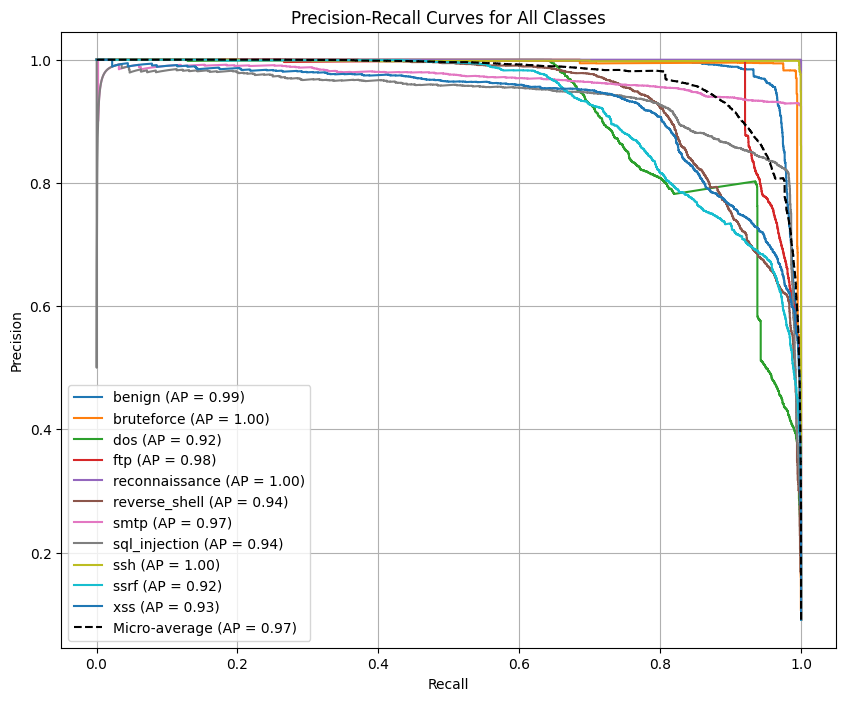


✅ Test Accuracy: 0.9085 - Test Loss: 0.2939
💾 Mô hình đã được lưu vào: mlp_webids23_model.h5


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.regularizers import l2
# ==== 1. Tên lớp gộp ====
class_names = [
    'benign', 'bruteforce', 'dos', 'ftp', 'reconnaissance',
    'reverse_shell', 'smtp', 'sql_injection', 'ssh', 'ssrf', 'xss'
]

# ==== 2. Hàm reshape an toàn ====
def safe_reshape(X, n_features=35):
    if len(X.shape) == 1:
        assert X.size % n_features == 0, "Tổng phần tử không chia hết cho số đặc trưng"
        X = X.reshape(-1, n_features)
    elif X.shape[1] != n_features:
        raise ValueError(f"Số đặc trưng không đúng. Mong đợi {n_features}, nhưng nhận được {X.shape[1]}")
    return X  # Không thêm chiều (1) nữa

# ==== 3. Load và xử lý dữ liệu ====
def load_data(data_path):
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy'))
    X_val   = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val   = np.load(os.path.join(data_path, 'y_val.npy'))
    X_test  = np.load(os.path.join(data_path, 'X_test.npy'))
    y_test  = np.load(os.path.join(data_path, 'y_test.npy'))

    X_train = safe_reshape(X_train, n_features=35)
    X_val   = safe_reshape(X_val, n_features=35)
    X_test  = safe_reshape(X_test, n_features=35)
    print("Phân bố lớp:", np.sum(y_train, axis=0))
    return X_train, y_train, X_val, y_val, X_test, y_test

# ==== 4. Xây dựng mô hình CNN ====

def build_mlp_model(input_dim=35, num_classes=11):
    model = Sequential()
    
    # Layer 1
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0005), input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Layer 2
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Layer 3
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0005)))
    
    # Output
    model.add(Dense(num_classes, activation='softmax'))
    
    # Optimizer
    optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# ==== 5. Biểu đồ training ====
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.tight_layout()
    plt.show()

# ==== 6. Ma trận nhầm lẫn ====
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    # Chuyển thành tỷ lệ phần trăm theo hàng (theo từng lớp thực)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = np.round(cm_percent * 100, 2)  # nhân 100 và làm tròn

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma Trận Nhầm lẫn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ==== 7. Precision-Recall ==== 
def plot_precision_recall(y_true_onehot, y_pred_probs, class_names):
    precision, recall, ap_score = dict(), dict(), dict()
    n_classes = y_true_onehot.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        ap_score[i] = average_precision_score(y_true_onehot[:, i], y_pred_probs[:, i])
        plt.plot(recall[i], precision[i], 
                 label=f"{class_names[i]} (AP = {ap_score[i]:.2f})")

    # Micro-average (tổng hợp toàn bộ)
    precision_micro, recall_micro, _ = precision_recall_curve(y_true_onehot.ravel(), y_pred_probs.ravel())
    ap_micro = average_precision_score(y_true_onehot, y_pred_probs, average="micro")
    plt.plot(recall_micro, precision_micro,
             label=f"Micro-average (AP = {ap_micro:.2f})", color='black', linestyle='--')

    plt.title("Precision-Recall Curves for All Classes")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

# ==== 8. Main pipeline ====
def main():
    data_path = r'D:/webids23_processed1/'
    print("🔄 Đang load dữ liệu...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    print("✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình CNN...")
    model = build_mlp_model(input_dim=35, num_classes=11)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    model.summary()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Huấn luyện xong. Hiển thị biểu đồ...")
    plot_history(history)

    print("🔎 Dự đoán trên tập test...")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("📊 Ma trận nhầm lẫn:")
    plot_confusion_matrix(y_true, y_pred, class_names)

    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\n📈 Precision-Recall từng lớp:")
    plot_precision_recall(y_test, y_pred_probs, class_names)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {test_acc:.4f} - Test Loss: {test_loss:.4f}")

    model.save("mlp_webids23_model.h5")
    print("💾 Mô hình đã được lưu vào: mlp_webids23_model.h5")


# ==== 9. Chạy chương trình ====
if __name__ == "__main__":
    main()
